## Introduction
This tutorial will expose you to some basic methods for analyzing large sets of data in the hopes of uncovering special trends and relationships that can better help the average viewer learn more about a topic.

In this tutorial we will attempt to discover what attributes makes an Oscar winning/nominated film Oscar worthy and hopefully find some interesting trends.

## Packages
Below are the packages we will be using. Pandas is a popular Data Science framework for its DataFrames which makes currating, scraping and parsing data simple and easy. Seaborn is a Data Visualization package which we will use to render our DataFrames into graphs. And statsmodels is a statistics library that we will be using to find relationships within our data.

In [363]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## 1. Load the Data
First we will want to load in our movie and Oscar datasets. You can obtain the .csv file from https://www.kaggle.com/antoniobap/imdb-v3/data. This dataset contains information from IMDb where rows are seperated into movies and contain data on cast, votes, budget, average rating, etc.

Then we want our Oscar dataset which can be downloaded from https://www.kaggle.com/theacademy/academy-awards/data which contains data on Oscar winners up until 2016.

Once you have downloaded the .csv file and placed them in the project directory, load them into seperate DataFrames using the pandas.read_csv() function.

In [364]:
movie_df = pd.read_csv('movie_metadata.csv', encoding='utf-8')
oscars_df = pd.read_csv('oscars_database.csv', encoding='utf-8')
movie_df.head()

,color,director_name,num_critic_for_reviews,duration,actor_2_name,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,...,Animation,Biography,Crime,sum_total_likes,ratio_movie_cast_likes,normalized_movies_likes,normalized_cast_likes,normalized10_movies_likes,normalized10_cast_likes,score
0,Color,Adam McKay,181.0,98.0,Will Ferrell,84136909.0,Darcy Donavan,Anchorman: The Legend of Ron Burgundy?,267921,656730.0,...,0,0,0,655285,0.0,1.0,100.00,1.00,10.00,4
1,Color,David R. Ellis,221.0,82.0,Andrew Fiscella,66466372.0,Krista Allen,The Final Destination?,75345,303717.0,...,0,0,0,301908,0.0,1.0,46.78,1.00,5.16,3
2,Color,Travis Romero,5.0,67.0,Lorraine Ziff,NaN,Matthew Ziff,Treachery?,344,283939.0,...,0,0,0,283004,0.0,1.0,43.80,1.00,4.89,2
3,Color,Johnny Remo,2.0,112.0,Randy Wayne,96734.0,Matthew Ziff,Hardflip?,606,263584.0,...,0,0,0,261949,0.0,1.2,40.73,1.02,4.61,3
4,NaN,John Stockwell,2.0,90.0,T.J. Storm,NaN,Matthew Ziff,Kickboxer: Vengeance?,246,261818.0,...,0,0,0,260942,0.0,1.0,40.47,1.00,4.59,5


Using the .head() function will show us the first 5 rows of our DataFrame. Above you can see what our movie data currently looks like. Lets do the same with our Oscar data to see what we are working with.

In [365]:
oscars_df.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


Here we have our Oscar data where each row is seperated into columns for the Year the award was given, which ceremony it was, the category of the award, who won (winner is represented by 1.0), Name of the recipient, and the Film title.

Lets use .shape to see how much data we currently have.

In [366]:
movie_df.shape

(5043, 50)

Here we can see that there are 5043 in our movies_df with at 50 different attributes for us to use. 50 seems like a lot though so in our next Section we are going to clean our data to get it into a format that we can easily work with.

In [367]:
oscars_df.shape

(9964, 6)

Here we see we have data on 9964 different Oscar awards each with 6 attributes.

## 1.2 Tidy Data
One of the most important steps in doing these kinds of analyses is to make sure our data is in a format that we can easily work with and contains all the necessary information that we need. Now is also the time to make sure the values of our DataFrame are usable, and if not, get them to a point where we can use them.

In this step we are going to drop any duplicate movies from our movie_df that might exists 

In [368]:
movie_df.drop_duplicates('movie_title',keep='last',inplace=True)

Currently our movie_df has 50 different attributes, most of which are useless to us. In this next step we want to reshape our DataFrame to only contain the attributes we need. Also if you notices in the movie_df, the movie_title for some reason has a question mark in its string, this will make it difficult to find Oscars associated with movie later on, therefore we are going to need to replace any instances of '?' with ''.

In [369]:
movie_df = movie_df[['director_name','actor_2_name','gross','actor_1_name','movie_title','num_voted_users','actor_3_name','budget','title_year','imdb_score']]
movie_df = movie_df.replace('\?','',regex=True)
movie_df.set_index('movie_title', inplace=True)
movie_df.dropna(axis=0, how='any', inplace=True)

Because we are trying to find out what makes a movie Oscar worthy, we need to know how many Oscars each movie has been nominated for/awarded. Therefore we should add an attribute that will hold that value.

In [370]:
movie_df['total_oscars'] = 0

Now to clean up our Oscar data. One issue that I found with the data is that starting around 1940 and earlier, the year column contains values that have two years like "19xx/19xx". To fix this we are just going to remove any year value that contains a '/'. This way we can convert all our year values from strings to ints which allows us to modify our DataFrames more easily. For instance, we are going to remove any movie that is before 1950.

In [371]:
oscars_df = oscars_df[oscars_df.Year.str.contains("/") == False]
oscars_df[["Year"]] = oscars_df[["Year"]].apply(pd.to_numeric)
oscars_df = oscars_df[oscars_df["Year"] >= 1950]

Here we are going to fill in out 'total_oscar' attribute for each movie in our movie_df. The way we will do this is by using the pd.groupby() function which takes the name of an attribute (or attributes) and groups together all rows that share a common value for that attribute which we can then analyze. In this step we are grouping together all awards from the Oscars DataFrame that have the same film title, and using the size of that group to determine how many awards that particular movie has been recognized for.

In [372]:
for name, group in oscars_df.groupby(['Name']):
    if name.rstrip() in movie_df.index:
        movie_df.at[name.rstrip(),'total_oscars'] += len(group)

movie_df.sort_values(by='total_oscars', ascending=False).head(10)

,director_name,actor_2_name,gross,actor_1_name,num_voted_users,actor_3_name,budget,title_year,imdb_score,total_oscars
movie_title,,,,,,,,,,
Titanic,James Cameron,Kate Winslet,658672302.0,Leonardo DiCaprio,793059,Gloria Stuart,200000000.0,1997.0,7.7,13
Forrest Gump,Robert Zemeckis,Siobhan Fallon Hogan,329691196.0,Tom Hanks,1251222,Sam Anderson,55000000.0,1994.0,8.8,11
The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,Orlando Bloom,313837577.0,Christopher Lee,1238746,Billy Boyd,93000000.0,2001.0,8.8,11
The Curious Case of Benjamin Button,David Fincher,Jason Flemyng,127490802.0,Brad Pitt,459346,Julia Ormond,150000000.0,2008.0,7.8,11
Mary Poppins,Robert Stevenson,Glynis Johns,102300000.0,Ed Wynn,107408,Elsa Lanchester,6000000.0,1964.0,7.8,11
Hugo,Martin Scorsese,Christopher Lee,73820094.0,Chlo Grace Moretz,245333,Ray Winstone,170000000.0,2011.0,7.5,11
Schindler's List,Steven Spielberg,Embeth Davidtz,96067179.0,Liam Neeson,865020,Caroline Goodall,22000000.0,1993.0,8.9,10
Mad Max: Fury Road,George Miller,Charlize Theron,153629485.0,Tom Hardy,552503,Zo Kravitz,150000000.0,2015.0,8.1,10
Master and Commander: The Far Side of the World,Peter Weir,Lee Ingleby,93926386.0,James D'Arcy,168207,David Threlfall,150000000.0,2003.0,7.4,10


One aspect we might want to analyze is whether or not the actors involved in the film have any influence on whether a film is Oscar worthy. In these next steps we will utilize our movie_df to create a new DataFrame where each row is associated with an actor and the columns hold values based on their films reception.

With the way movie_df is formatted right now it would be difficult to pick out the values we want for each actor and insert them into the new DataFrame. This is because there are 3 seperate attributes for actors in a film in our movie_df, so in order to find which films an actor was in we would have to search for their name in each of the actor columns. What would be easier is if we could reformat our movie_df so that the cast of a film is spread out across multiple rows with each row still having all the data associated with the film. To do this we will use pd.melt which will create new rows for each of the actors in the 3 seperate columns.

In [373]:
actors_df = pd.melt(movie_df, id_vars=['director_name','num_voted_users','imdb_score'], value_vars=['actor_1_name','actor_2_name','actor_3_name'], value_name='actor')
actors_df = actors_df.drop('variable', axis=1)
actors_df.head()

,director_name,num_voted_users,imdb_score,actor
0,Adam McKay,267921,7.2,Darcy Donavan
1,David R. Ellis,75345,5.2,Krista Allen
2,Johnny Remo,606,5.6,Matthew Ziff
3,John Erick Dowdle,57446,6.0,Andrew Fiscella
4,Nimrd Antal,26236,5.7,Andrew Fiscella


From here we want to make a new DataFrame where each index is an actor and the columns are values for total votes on movies, total stars, average votes per movie, and average stars per movie.

In [374]:
sum_df = actors_df.groupby('actor')['num_voted_users','imdb_score'].sum()
sum_df.columns = ['total_votes','total_stars']
avg_df = actors_df.groupby('actor')['num_voted_users','imdb_score'].mean()
avg_df.columns = ['avg_votes','avg_stars']
cast_df = sum_df.join(avg_df)
cast_df['total_oscars'] = 0
for name, group in oscars_df[(oscars_df['Award'].str.contains('Actor')) | (oscars_df['Award'].str.contains('Actress'))].groupby(['Name']):
    if name in cast_df.index:
        cast_df.at[name,'total_oscars'] = len(group)
cast_df.sort_values(by='total_oscars',ascending=False).head(10)

,total_votes,total_stars,avg_votes,avg_stars,total_oscars
actor,,,,,
Meryl Streep,1822828,156.6,79253.391304,6.808696,19
Al Pacino,4339699,139.1,216984.950000,6.955000,8
Marlon Brando,2243349,57.3,280418.625000,7.162500,8
Richard Burton,27913,13.8,13956.500000,6.900000,7
Robert Duvall,3910748,145.0,186226.095238,6.904762,7
Robert De Niro,6447442,315.0,137179.617021,6.702128,7
Kate Winslet,3367632,140.9,168381.600000,7.045000,7
Jane Fonda,118139,18.0,39379.666667,6.000000,7
Spencer Tracy,29323,7.6,29323.000000,7.600000,6


We are going to do the same for the directors of the films as well since they also may have an impact on Oscar worthiness.

In [375]:
sum_df = movie_df.groupby('director_name')['num_voted_users','imdb_score'].sum()
sum_df.columns = ['total_votes','total_stars']
avg_df = movie_df.groupby('director_name')['num_voted_users','imdb_score'].mean()
avg_df.columns = ['avg_votes','avg_stars']
director_df = sum_df.join(avg_df)
director_df['total_oscars'] = 0
for name, group in oscars_df[(oscars_df['Award'] == 'Directing')].groupby(['Name','Film']):
    if name[0] in director_df.index:
        director_df.at[name[0],'total_oscars'] += len(group)
    if name[1] in director_df.index:
        director_df.at[name[1],'total_oscars'] += len(group)
director_df.sort_values(by='total_oscars', ascending=False).head(10)   

,total_votes,total_stars,avg_votes,avg_stars,total_oscars
director_name,,,,,
Martin Scorsese,4965085,122.8,310317.812500,7.675,8
Steven Spielberg,8273101,188.6,330924.040000,7.544,7
Woody Allen,1501719,133.0,79037.842105,7.000,7
Billy Wilder,175196,8.3,175196.000000,8.300,6
David Lean,411015,32.0,102753.750000,8.000,5
William Wyler,40359,8.1,40359.000000,8.100,5
Robert Altman,88392,20.4,29464.000000,6.800,5
Sidney Lumet,66700,26.1,16675.000000,6.525,4
Mike Nichols,332334,32.9,66466.800000,6.580,4


Using these new tables, lets create some more attributes for out movie_df that we can use to futher analyze what makes an Oscar worthy movie. We are going to add star_power and cast_oscars attributes to each row. The star_power attribute will hold a value that indicates the average amount of stars the actors and director received on all their works. Using this we can find if there is a trend between a prestigious cast and an Oscar worthy film. cast_oscars will be the total number of wins/nominations the actors and director have received on all their works. This will help answer the question of whether a cast of Oscar nominees/winners makes a film more oscar worthy.

In [376]:
movie_df['star_power'] = 0.0
movie_df['cast_oscars'] = 0
for index, row in movie_df.iterrows():
    star_power = cast_df.loc[row['actor_1_name']]['avg_stars'] + cast_df.loc[row['actor_2_name']]['avg_stars'] + cast_df.loc[row['actor_3_name']]['avg_stars'] + director_df.loc[row['director_name']]['avg_stars']
    star_power = star_power / 4.0
    cast_oscars = cast_df.loc[row['actor_1_name']]['total_oscars'] + cast_df.loc[row['actor_2_name']]['total_oscars'] + cast_df.loc[row['actor_3_name']]['total_oscars'] + director_df.loc[row['director_name']]['total_oscars']
    movie_df.set_value(index, 'star_power', star_power)
    movie_df.set_value(index, 'cast_oscars', cast_oscars)
movie_df.sort_values(by='total_oscars', ascending=False).head(10)  

,director_name,actor_2_name,gross,actor_1_name,num_voted_users,actor_3_name,budget,title_year,imdb_score,total_oscars,star_power,cast_oscars
movie_title,,,,,,,,,,,,
Titanic,James Cameron,Kate Winslet,658672302.0,Leonardo DiCaprio,793059,Gloria Stuart,200000000.0,1997.0,7.7,13,7.544583,15
Forrest Gump,Robert Zemeckis,Siobhan Fallon Hogan,329691196.0,Tom Hanks,1251222,Sam Anderson,55000000.0,1994.0,8.8,11,7.758173,6
The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,Orlando Bloom,313837577.0,Christopher Lee,1238746,Billy Boyd,93000000.0,2001.0,8.8,11,7.519818,2
The Curious Case of Benjamin Button,David Fincher,Jason Flemyng,127490802.0,Brad Pitt,459346,Julia Ormond,150000000.0,2008.0,7.8,11,7.033268,5
Mary Poppins,Robert Stevenson,Glynis Johns,102300000.0,Ed Wynn,107408,Elsa Lanchester,6000000.0,1964.0,7.8,11,7.800000,4
Hugo,Martin Scorsese,Christopher Lee,73820094.0,Chlo Grace Moretz,245333,Ray Winstone,170000000.0,2011.0,7.5,11,6.876233,8
Schindler's List,Steven Spielberg,Embeth Davidtz,96067179.0,Liam Neeson,865020,Caroline Goodall,22000000.0,1993.0,8.9,10,7.586417,8
Mad Max: Fury Road,George Miller,Charlize Theron,153629485.0,Tom Hardy,552503,Zo Kravitz,150000000.0,2015.0,8.1,10,6.816288,4
Master and Commander: The Far Side of the World,Peter Weir,Lee Ingleby,93926386.0,James D'Arcy,168207,David Threlfall,150000000.0,2003.0,7.4,10,7.131250,4


Now that we have gotten our data nice and tidy there is one last step before we analyze the data. We only want to consider movies that have been nominated and/or won Oscars, therefore we simply need to remove any rows from our movie_df that have 0 total_oscars.

In [377]:
movie_df = movie_df[movie_df['total_oscars'] > 0]
movie_df.shape

(667, 12)

## 2. Exploratory Data Analysis
Now that we have tidy data we can begin to create visual representations of certain aspects of our DataFrame. Because we are interested in Oscar worthiness, all plots will be against total oscars.

Here is an example. Below is a histogram with a distribution plot. What's interesting to note here is that, for the IMDb scores of the movies in our DataFrame, it appears as though there is a normal distribution. Already we see a trend that movies around a 7.8 IMDb score are most likely to get the Oscar nod.

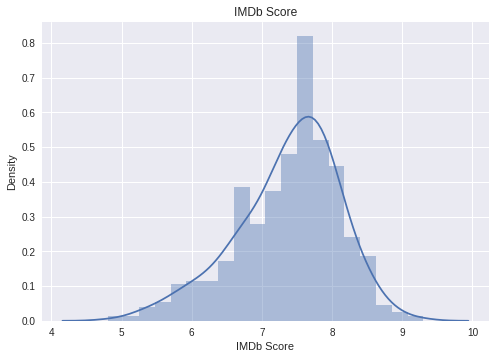

In [378]:
with sns.axes_style("darkgrid"):
    sns.distplot(movie_df['imdb_score'])
    plt.xlabel('IMDb Score')
    plt.ylabel('Density')
    plt.title('IMDb Score')
    plt.show()

Now lets use seaborn to create scatterplots fit with regression lines to evaluate total_oscars against different attributes

### IMDb Score vs. Total Nominated/Won Oscars
Because the best fit line is not flat it insdicates that there is a relationship between IMDb Score and total Oscars. This would make logical sense since well reviewed movies tend to win awards. What is interesting however is, like in our histogram above, the highest concntration of Oscar worthy films are around 7.8. This is probably due to the fact that 7.8 is already an exceptional score and since it is rare for films to score above 8's our graph becomes less dense towards the upper bound. However, those movies that do score above 7.8 tend to win multiple oscars.

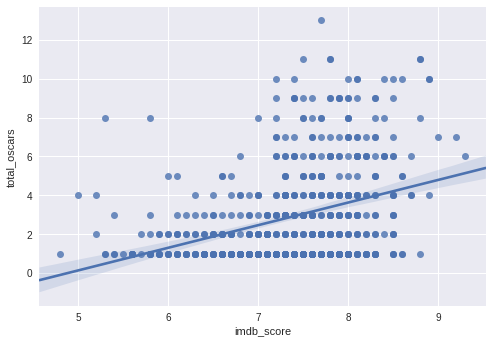

In [379]:
ax = sns.regplot(x="imdb_score", y="total_oscars", data=movie_df)
sns.plt.show()

### Number of Votes vs. Total Nominated/Won Oscars
There seems to be a strong correlation between the number of users who voted on a movie and total oscars won. This would also make sense as popular movies typically are well received movies. You can see that as almost all the points beyond the 500,000 votes mark have are worthy of multiple Oscars.

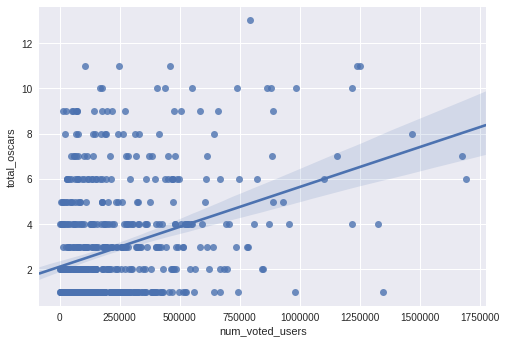

In [380]:
ax = sns.regplot(x="num_voted_users", y="total_oscars", data=movie_df)
sns.plt.show()

### Budget vs. Total Nominated/Won Oscars
Here we see the first case where one of our attributes seemingly has no relationship to Oscar worthiness. The best fit line is practically meaning the points are mostly scattered rather than following some trend.

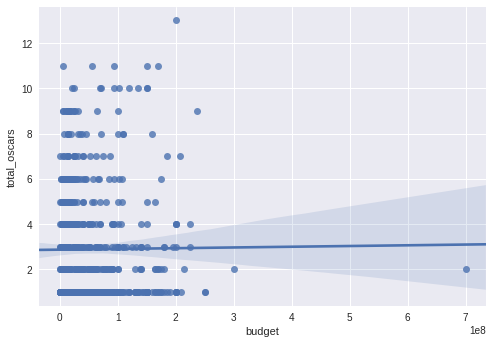

In [381]:
ax = sns.regplot(x="budget", y="total_oscars", data=movie_df)
sns.plt.show()

### Gross vs. Total Nominated/Won Oscars
Here we see another strong correlation. Like the number of votes on a movie, gross can be an indication of popularity, and like we saw before, popular movies tend to be special and therefore worthy of Oscars.

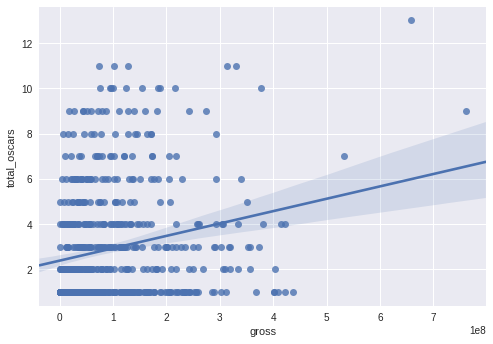

In [382]:
ax = sns.regplot(x="gross", y="total_oscars", data=movie_df)
sns.plt.show()

### Star Power vs. Total Nominated/Won Oscars
This plot of star power almost resembles the same shape of the IMDb scores plot. Prestigious actors and directors are born out of Award worthy films, therefore it would only be logical that having a taleted cast would make a movie more Oscar worthy

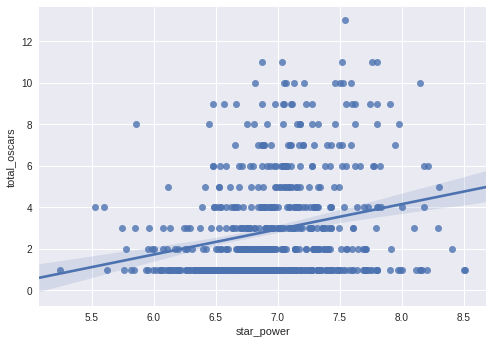

In [383]:
ax = sns.regplot(x="star_power", y="total_oscars", data=movie_df)
sns.plt.show()

### Cast Oscars vs. Total Nominated/Won Oscars
In this graph we examine if there is a relationship between the number of Oscar nods a cast has collectively and te total Oscar nods for a film. Similar to the Star power graph, it makes sense that there would be some sort of relationship as having a more prestigious cast makes better films.

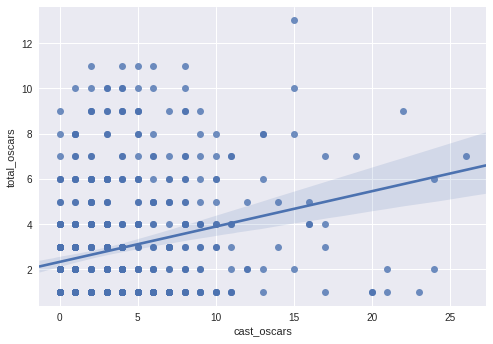

In [384]:
ax = sns.regplot(x="cast_oscars", y="total_oscars", data=movie_df)
sns.plt.show()

## 3. Null Hypothesis and Machine Learning
For this next section we are going to take all the relationships that had a trending best fit line and examine their p-value and f-statistic by fitting the data with an OLS model to see which attribute is the best indicator of Oscar worhtiness.

In [385]:
est = smf.ols(formula='total_oscars ~ imdb_score', data=movie_df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_oscars   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     95.23
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           4.08e-21
Time:                        10:39:22   Log-Likelihood:                -1497.3
No. Observations:                 667   AIC:                             2999.
Df Residuals:                     665   BIC:                             3008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6789      0.883     -6.432      0.0

In [386]:
est = smf.ols(formula='total_oscars ~ num_voted_users', data=movie_df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_oscars   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     95.18
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           4.17e-21
Time:                        10:39:22   Log-Likelihood:                -1497.3
No. Observations:                 667   AIC:                             2999.
Df Residuals:                     665   BIC:                             3008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1212      0.119     

In [387]:
est = smf.ols(formula='total_oscars ~ gross', data=movie_df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_oscars   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     33.70
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           9.98e-09
Time:                        10:39:22   Log-Likelihood:                -1525.4
No. Observations:                 667   AIC:                             3055.
Df Residuals:                     665   BIC:                             3064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3924      0.126     18.921      0.0

In [388]:
est = smf.ols(formula='total_oscars ~ star_power', data=movie_df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_oscars   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     41.10
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           2.74e-10
Time:                        10:39:22   Log-Likelihood:                -1521.9
No. Observations:                 667   AIC:                             3048.
Df Residuals:                     665   BIC:                             3057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5668      1.323     -4.208      0.0

In [389]:
est = smf.ols(formula='total_oscars ~ cast_oscars', data=movie_df).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           total_oscars   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     51.79
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           1.67e-12
Time:                        10:39:22   Log-Likelihood:                -1516.9
No. Observations:                 667   AIC:                             3038.
Df Residuals:                     665   BIC:                             3047.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.3366      0.120     19.535      

The F-statistic is an indicator for how significant a relationship there is between the variable and the population. Therefore the larger the f-statistic the better indicator that attribute is for Oscar worthiness. Going through the results we see that the f-statistics for the IMDb Score = 95.23, num_voted_users = 95.18, gross = 33.70, star_power = 41.10, and cast_oscars = 51.79. Therefore the best indicator of Oscar worthiness comes from the IMDb score by just 0.05.

## Wrap Up
So there you have it. Most of you could have probably guessed it without this page, but from our data analyses we found that the best indicator or Oscar wrothiness comes from the film's IMDb score, with most films getting the Oscar nod around a 7.8. This tutorial was meant to show you basic methods and techniques of gathering data, tidying it in a significant way, vizualizing the results, and analyzing some of the more significant statistics. It would be interesting to take this project a step further and see if a combination of different attributes gives us a better indicator as to which movies are Oscar worthy, but for now we'll stick with this.

## Resources
Use the following links to get more information on the packages we used
Pandas - https://pandas.pydata.org/pandas-docs/stable/
matplotlib - https://matplotlib.org/api/pyplot_api.html
seaborn - https://seaborn.pydata.org/
NumPy - https://docs.scipy.org/doc/numpy-1.13.0/reference/
statsmodels.formula.api - http://www.statsmodels.org/stable/index.html
